# 4. 数据计算与统计试题

4.1计算股票600104与600518的相关系数、spearman排序相关性与30天滚动的五日收益协方差

In [5]:
import pandas as pd
stock1 = pd.read_excel(r'C:\Users\Administrator\Desktop\hyn\python\sz50.xlsx',sheetname='600104.XSHG', index_col='datetime')
stock2 = pd.read_excel(r'C:\Users\Administrator\Desktop\hyn\python\sz50.xlsx',sheetname='600518.XSHG', index_col='datetime')
five_day_df = pd.concat([stock1.close.pct_change(5),stock2.close.pct_change(5)],keys=['stock1','stock2'],axis=1)
correlation = five_day_df.corr()
print(correlation)

          stock1    stock2
stock1  1.000000  0.348809
stock2  0.348809  1.000000


In [6]:
spearman = five_day_df.corr(method='spearman')
print(spearman)

         stock1   stock2
stock1  1.00000  0.38035
stock2  0.38035  1.00000


In [7]:
cov_30 = five_day_df.rolling(30).cov()
print(cov_30.tail(6))

                              stock1    stock2
datetime                                      
2017-11-16 15:00:00 stock1  0.001200  0.000289
                    stock2  0.000289  0.000682
2017-11-17 15:00:00 stock1  0.001196  0.000291
                    stock2  0.000291  0.000710
2017-11-20 15:00:00 stock1  0.001192  0.000318
                    stock2  0.000318  0.000696


4.2
读取600104.XSHG的股票日线

利用正确的方法将日K线聚合成周K线

将周K线画出来

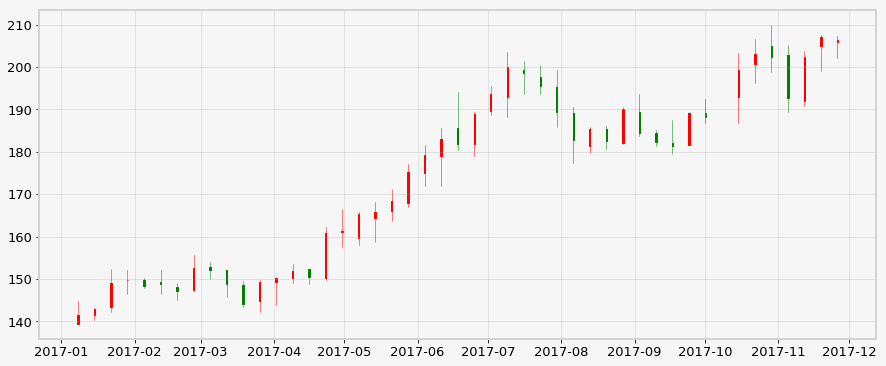

In [8]:
stock1 = stock1.resample('W').agg({'high':'max','low':'min', 'close':'last', 'open':'first'})
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num

stock1['time'] = list(map(date2num, stock1.index))
candle = stock1.reindex_axis(["time", "open", "high", "low", "close"], 1).values

import mpl_finance as mpf

fig, (ax) = plt.subplots(1,1, figsize=(15,12))
fig.subplots_adjust(bottom=0.5)
ax.grid(True)
mpf.candlestick_ohlc(ax, candle, width=0.6, colorup='r', colordown='g',alpha=1.0)
ax.xaxis_date ()
plt.show()

4.3 读取股票601857数据，计算股票回报率，判断样本在2017-01-01,到2017-12-31，有没有服从正态分布，并判断样本均值是否为0

In [9]:
from statsmodels.stats.stattools import jarque_bera
stock3 = pd.read_excel(r'C:\Users\Administrator\Desktop\hyn\python\sz50.xlsx',sheetname='601857.XSHG', index_col='datetime')
stock3['percentage']=stock3['close'].pct_change()
returns = stock3['percentage'][1:]
_, pvalue, _, _ = jarque_bera(returns)
if pvalue > 0.05:
    print ('判断样本分布服从正态分布')
else:
    print ('判断样本分布不服从正态分布')

判断样本分布不服从正态分布


In [10]:
from scipy import stats
t_test = stats.ttest_1samp(returns, 0)
if t_test.pvalue > 0.05:
    print ('判断样本均值为0')
else:
    print ('判断样本均值不为0')

判断样本均值为0


4.4 用Pandas的递归函数计算EMA与DEMA，对比talib的EMA与DEMA
1. 根据以上的算法，利用Pandas的ewm方法计算601901.XSHG以10天为周期的EMA，再算出DEMA。
2. 用talib计算601901.XSHG以10天为周期的EMA，再算出DEMA。
3. 打印两个结果的最后5个数据

In [11]:
stock4 = pd.read_excel(r'C:\Users\Administrator\Desktop\hyn\python\sz50.xlsx',sheetname='601901.XSHG', index_col='datetime')
ema=stock4.ewm(span=10).mean()
dema=2*ema-ema.ewm(span=10).mean()
print(dema['close'][-5:])

datetime
2017-11-14 15:00:00    8.602581
2017-11-15 15:00:00    8.572151
2017-11-16 15:00:00    8.479642
2017-11-17 15:00:00    8.354917
2017-11-20 15:00:00    8.299691
Name: close, dtype: float64


In [12]:
import talib as ta
ema = pd.DataFrame({'ema':ta.EMA(stock4.close.values,10)},index=stock4.index)
dema = pd.DataFrame({'dema':ta.DEMA(stock4.close.values,10)},index=stock4.index)
print(dema['dema'][-5:])

datetime
2017-11-14 15:00:00    8.602581
2017-11-15 15:00:00    8.572151
2017-11-16 15:00:00    8.479642
2017-11-17 15:00:00    8.354917
2017-11-20 15:00:00    8.299691
Name: dema, dtype: float64


# 5.分析工具

数据时间：  'start_date': 20140101, 'end_date': 20180101, '

5.1 用alphalens分析沪深300成分股里float_mv因子在5日、30日、60日持有期下的因子表现。 （要求：按上证交易所上市、深证交易所上市分组，绘制ic柱状图比较不同组在不同持有期下的ic差异）-最后结果输出类似下面的表和图。

In [13]:
from jaqs_fxdayu.data import DataView 
import os
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
dataview_folder = r'C:\Users\Administrator\Desktop\Factor'
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index)) 
    return df
dv = DataView()
dv.load_dataview(dataview_folder)
prices = dv.get_ts("close_adj") 
prices = change_index(prices)
factor = dv.get_ts("float_mv")
factor = change_index(factor)
factor = factor.stack()

Dataview loaded successfully.


In [14]:
sectors = dv.get_ts("sw1")
sectors = change_index(sectors)
import re
import alphalens
for eachcol in sectors.columns:
    try:
        sectors[eachcol] = re.split("\.",eachcol)[1]
    except:
        pass
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   prices,
                                                                   groupby=sectors.stack(),
                                                                   quantiles=5,
                                                                   periods=(5, 30, 60))
ic_by_sector = alphalens.performance.mean_information_coefficient(factor_data, by_group=True)
print(ic_by_sector)

Dropped 6.4% entries from factor data (6.4% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
             5         30        60
group                              
SH    -0.019890 -0.011939  0.004947
SZ    -0.031756 -0.049609 -0.058176
nan         NaN       NaN       NaN


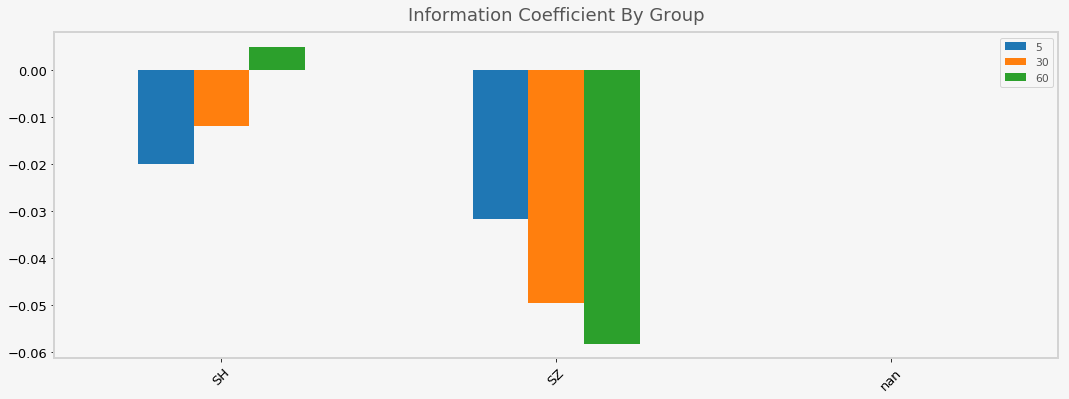

In [15]:
from matplotlib import pyplot as plt

alphalens.plotting.plot_ic_by_group(ic_by_sector)
plt.show()

5.2（大致输出结果有下图）

5.2.1可视化比较CCI、Divert（习题定义）、pb的10日变化率、vwap_adj的10日变化率 这4个因子在5日、30日、60日持有期下的平均IC和IC_IR

5.2.2挑选上题中5日IC_IR最大的3个因子进行因子组合（注意需对因子进行去极值和z-score标准化处理，最终的组合因子也需要进行z-score标准化处理），并用柱状图比较各组合方法生成的因子与原因子在5日持有期下的IC和IC_IR；调用指标分析和可视化分析的方法，查看ic_weight方法合成的因子绩效，保存该合成方法下绩效最好quantile的选股结果

Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


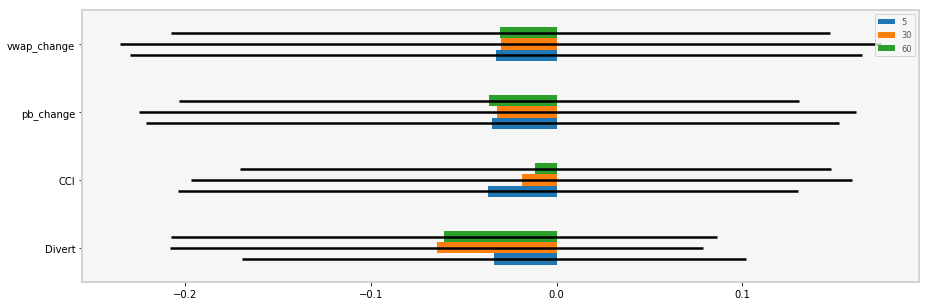

In [16]:
dv.add_formula("Divert", "Correlation(close_adj,volume,20)", is_quarterly=False,add_data=True)
from jaqs_fxdayu.research.signaldigger import process
High = dv.get_ts("high_adj")
Low = dv.get_ts("low_adj")
Close = dv.get_ts("close_adj")
trade_status = dv.get_ts('trade_status')
mask_sus = trade_status == 0
high_masked = process._mask_df(High,mask=mask_sus)
low_masked = process._mask_df(Low,mask=mask_sus)
close_masked = process._mask_df(Close,mask=mask_sus)
from jaqs_fxdayu.data import signal_function_mod as sfm
CCI = sfm.ta(ta_method='CCI',
             ta_column=0, 
             High=high_masked, 
             Low=low_masked, 
             Close=close_masked,
             Volume=None,
             timeperiod=10)
dv.append_df(CCI,'CCI')
dv.add_formula("pb_change", "Return(pb, 10)", is_quarterly=False,add_data=True)
dv.add_formula("vwap_change", "Return(vwap_adj, 10)", is_quarterly=False,add_data=True)
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) 
    return mask_index_member

def limit_up_down():
    
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == 0
    
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) 
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) 
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()
from jaqs_fxdayu.research.signaldigger import multi_factor

ic = dict()
factors_dict = {signal:dv.get_ts(signal) for signal in ["Divert","CCI","pb_change","vwap_change"]}
for period in [5, 30, 60]:
    ic[period]=multi_factor.get_factors_ic_df(factors_dict,
                                              price=dv.get_ts("close_adj"),
                                              high=dv.get_ts("high_adj"), 
                                              low=dv.get_ts("low_adj"),
                                              n_quantiles=5,
                                              mask=mask,
                                              can_enter=can_enter,
                                              can_exit=can_exit,
                                              period=period,
                                              benchmark_price=dv.data_benchmark, 
                                              commission = 0.0008,
                                              )
ic_mean_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])
ic_std_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])
ir_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])
for signal in ["Divert","CCI","pb_change","vwap_change"]:
    for period in [5,30,60]:
        ic_mean_table.loc[signal,period]=ic[period][signal].mean()
        ic_std_table.loc[signal,period]=ic[period][signal].std()
        ir_table.loc[signal,period]=ic[period][signal].mean()/ic[period][signal].std()
%matplotlib inline
ic_mean_table.plot(kind="barh",xerr=ic_std_table,figsize=(15,5))

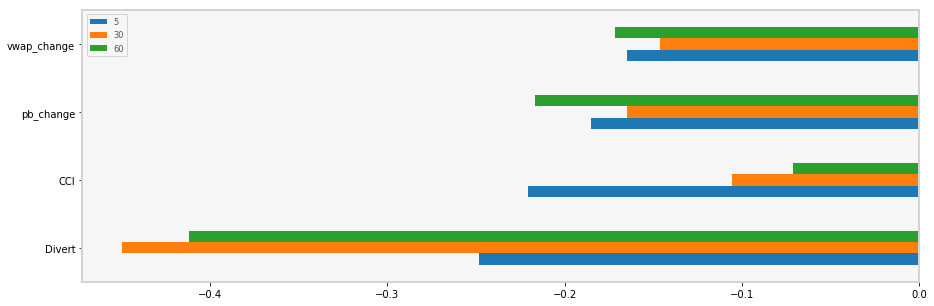

In [17]:
%matplotlib inline
ir_table.plot(kind="barh",figsize=(15,5))

### 比较组合前和组合后的因子在5日持有期下的表现（统一到2014年9月后进行比较）

In [31]:
from jaqs_fxdayu.research.signaldigger import process

factor_dict = dict()
index_member = dv.get_ts("index_member")
for name in ["Divert","CCI","pb_change"]:
    signal = -1*dv.get_ts(name) 
    process.winsorize(factor_df=signal,alpha=0.05,index_member=index_member)
    signal = process.standardize(signal,index_member)
    factor_dict[name] = signal
props = {
    'price':dv.get_ts("close_adj"),
    'high':dv.get_ts("high_adj"), 
    'low':dv.get_ts("low_adj"),
    'ret_type': 'return',
    'benchmark_price': dv.data_benchmark,  
    'period': 5, 
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "shrink",  
    "rollback_period": 120} 
comb_factors = dict()
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    comb_factors[method] = multi_factor.combine_factors(factor_dict,
                                                        standardize_type="z_score",
                                                        winsorization=False,
                                                        weighted_method=method,
                                                        props=props)
period = 5
ic_5  =   multi_factor.get_factors_ic_df(comb_factors,
                                          price=dv.get_ts("close_adj"),
                                          high=dv.get_ts("high_adj"), 
                                          low=dv.get_ts("low_adj"),
                                          n_quantiles=5,
                                          mask=mask,
                                          can_enter=can_enter,
                                          can_exit=can_exit,
                                          period=period,
                                          benchmark_price=dv.data_benchmark,
                                          commission = 0.0008,
                                          )
ic_5 = pd.concat([ic_5,-1*ic[5].drop("vwap_change",axis=1)],axis=1)
ic_5_mean = dict()
ic_5_std = dict()
ir_5 = dict()
for name in ic_5.columns:    
    ic_5_mean[name]=ic_5[name].loc[20140901:].mean()
    ic_5_std[name]=ic_5[name].loc[20140901:].std()
    ir_5[name] = ic_5_mean[name]/ic_5_std[name]
import datetime

trade_date = pd.Series(ic_5.index)
trade_date = trade_date.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
ic_5.index = trade_date


Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective da

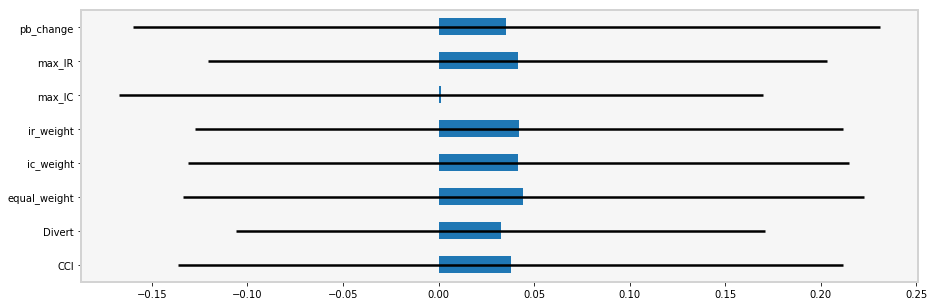

In [33]:
pd.Series(ic_5_mean).plot(kind="barh",xerr=pd.Series(ic_5_std),figsize=(15,5))

In [35]:
print(ic_5_mean["CCI"])
print(ic_5_mean["pb_change"])
print(ic_5_mean["Divert"])

0.03775298869012131
0.03554436686494026
0.03254090873516835


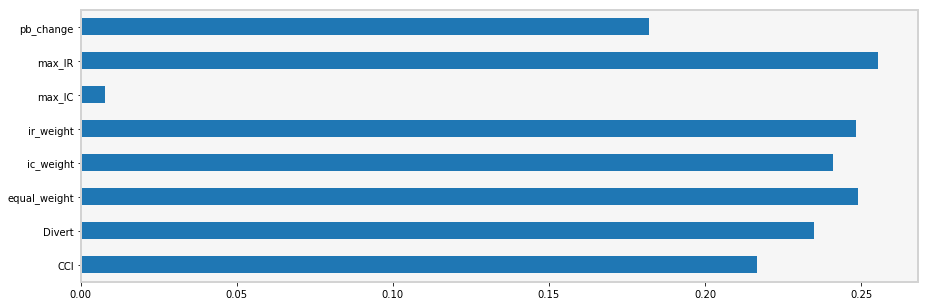

In [36]:
pd.Series(ir_5).plot(kind="barh",figsize=(15,5))

In [41]:
print(ir_5["CCI"])
print(ir_5["pb_change"])
print(ir_5["Divert"])

0.249174274482778
0.2411671275983589
0.2484909298353155


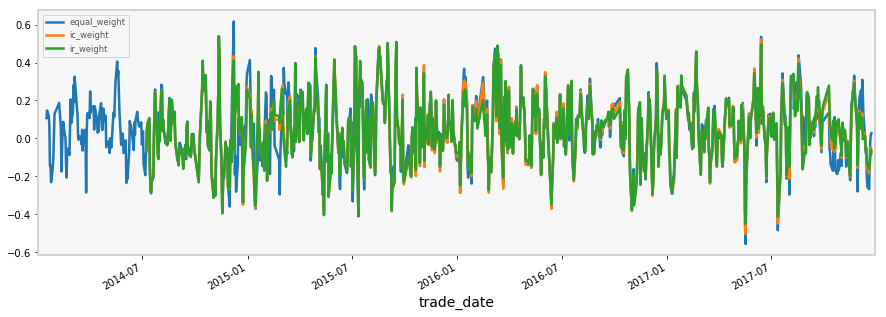

In [39]:
ic_5[["equal_weight","ic_weight","ir_weight"]].plot(kind="line",figsize=(15,5),)

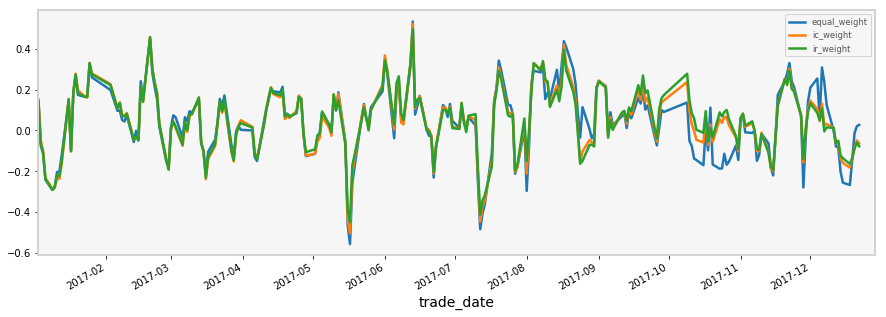

In [40]:
ic_5.loc[datetime.date(2017,1,3):,][["equal_weight","ic_weight","ir_weight"]].plot(kind="line",figsize=(15,5),)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 50%


Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -6.901427 -0.297994 -1.373450  0.607576  47360  20.135883
2        -2.814686  0.186351 -0.447448  0.206279  47033  19.996854
3        -2.358868  0.555738  0.035096  0.174165  47071  20.013010
4        -1.490407  1.079069  0.498640  0.181305  47033  19.996854
5        -0.582021  6.946390  1.330235  0.590226  46705  19.857399
Figure saved: C:\Users\Administrator\Desktop\houyanan\OFO\作业\returns_report.pdf
Information Analysis
                ic
IC Mean      0.041
IC Std.      0.172
t-stat(IC)   6.970
p-value(IC)  0.000
IC Skew      0.002
IC Kurtosis  0.053
Ann. IR      0.239
Figure saved: C:\Users\Administrator\Desktop\houyanan\OFO\作业\information_report.pdf


<Figure size 432x288 with 0 Axes>

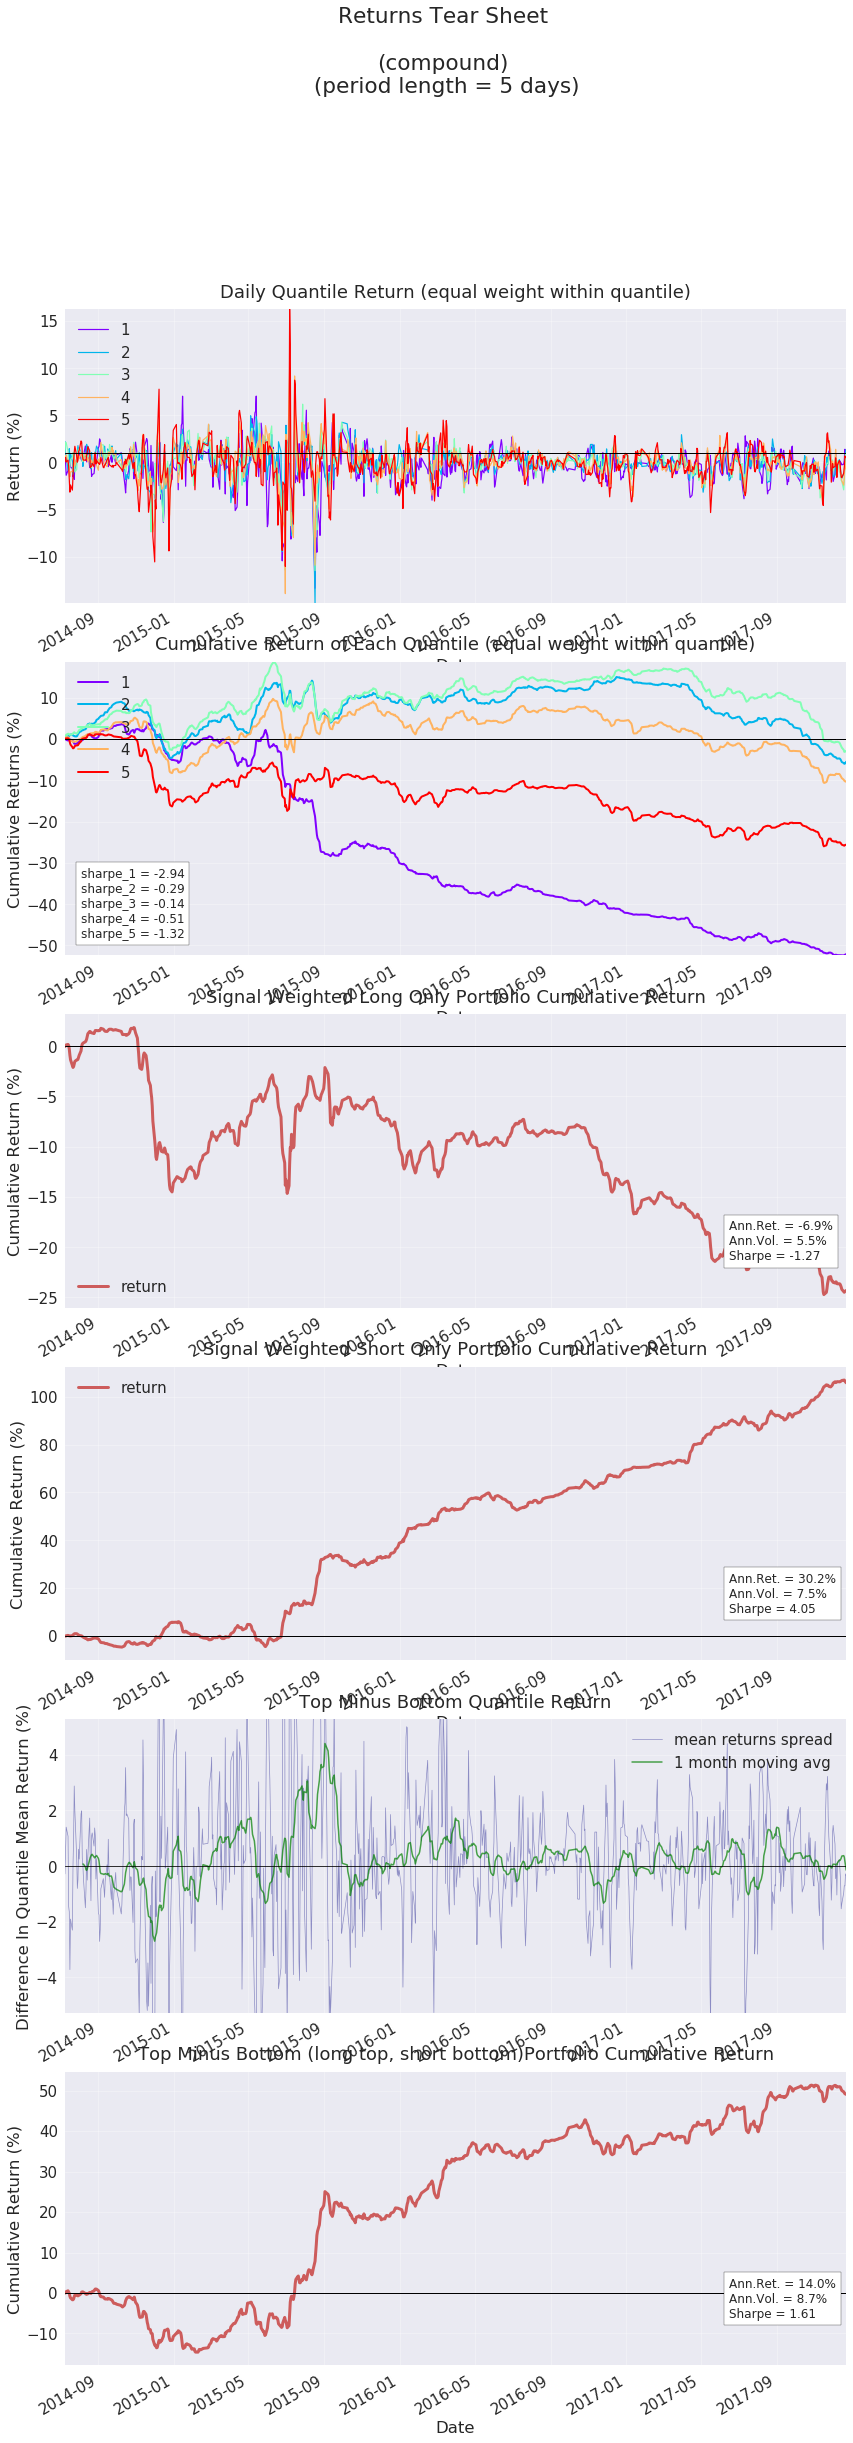

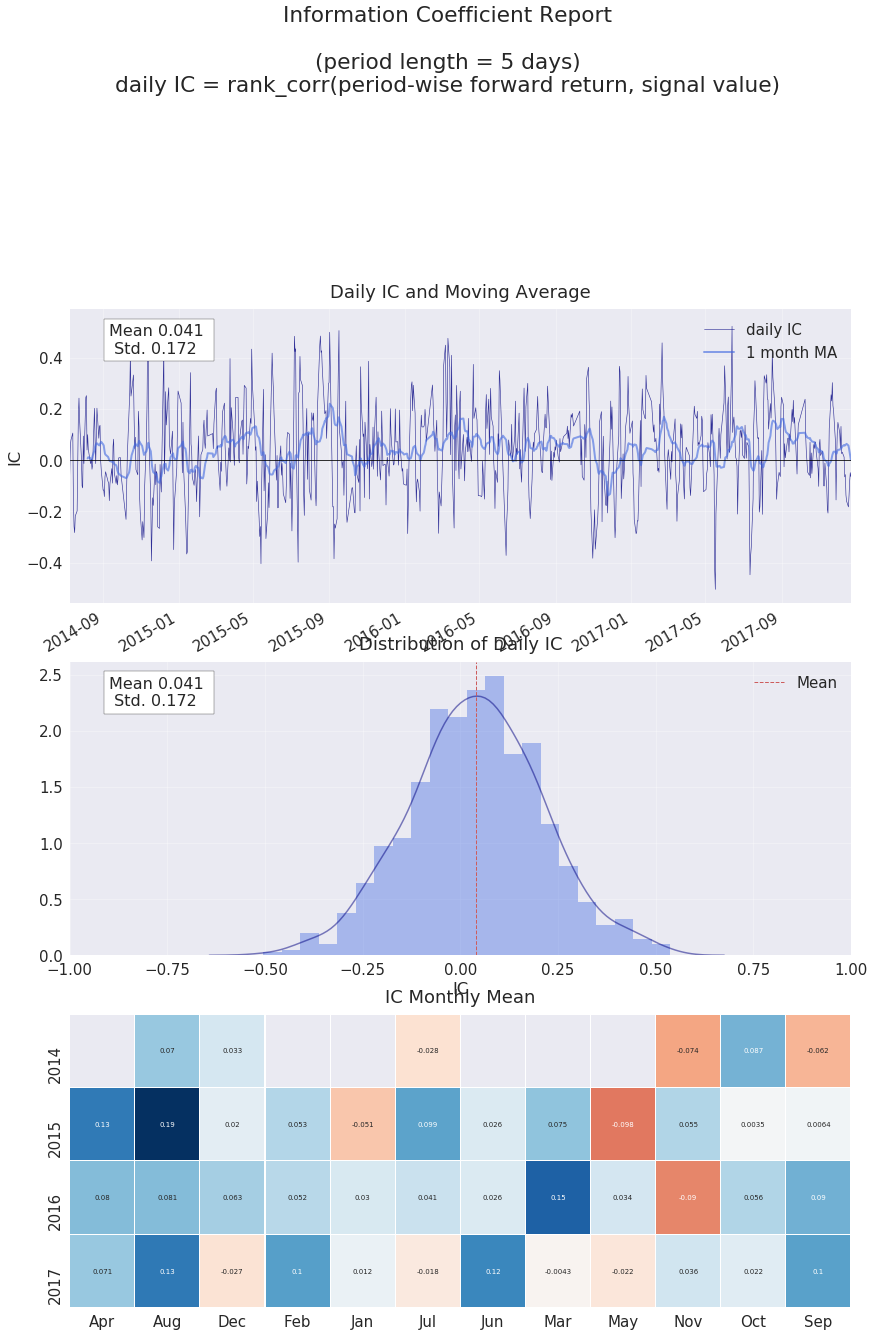

In [42]:
import matplotlib.pyplot as plt
from jaqs_fxdayu.research.signaldigger.analysis import analysis
from jaqs_fxdayu.research import SignalDigger

obj = SignalDigger()
obj.process_signal_before_analysis(signal=comb_factors["ic_weight"],
                                   price=dv.get_ts("close_adj"),
                                   high=dv.get_ts("high_adj"),
                                   low=dv.get_ts("low_adj"),
                                   n_quantiles=5,
                                   mask=mask,
                                   can_enter=can_enter,
                                   can_exit=can_exit,
                                   period=5,
                                   benchmark_price=dv.data_benchmark, 
                                   commission = 0.0008,
                                   )
obj.create_full_report()
plt.show()

In [43]:
excel_data = obj.signal_data[obj.signal_data['quantile']==3]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
excel_data.to_excel('./equal_weight_quantile_3.xlsx')


5.3. 优化动量因子momentum：vwap_adj的n日变化率中的参数n（2<=n<=10）。优化目标是10日持有期的IC的IR。（要求：进行样本内优化，优化所用数据时段20140101~20170101，查看样本外20170101~表现，大致输出以下结果）

In [44]:
from jaqs_fxdayu.data import DataView 
import warnings

warnings.filterwarnings("ignore")
dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [45]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) 
    return mask_index_member

def limit_up_down():
    
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == 0
    
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) 
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) 
    return can_enter,can_exit

In [46]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()

In [57]:
from jaqs_fxdayu.research import Optimizer
price = dv.get_ts('close_adj')
high = dv.get_ts('high_adj')
low = dv.get_ts('low_adj')
price_bench = dv.data_benchmark
optimizer = Optimizer(dataview=dv,
                      formula='-Return(vwap_adj,LEN)',
                      params={"LEN":range(2,11,1)},
                      name='momentum',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,
                      period=10,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,
                      is_event=False,
                      is_quarterly=False)

In [60]:
ret_best = optimizer.enumerate_optimizer(target_type="return_ic",
                                         target="Ann. IR",   
                                         in_sample_range=[20140101,20170101],
                                         ascending=False)

In [62]:
print(ret_best[0]["signal_name"])
print(ret_best[0]["ic"])
print(ret_best[0]["ret"])
print(ret_best[0]["space"])

momentum{'LEN': 10}
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean      3.952566e-02      -0.036770     1.021542e-01
IC Std.      1.886946e-01       0.204269     1.879025e-01
t-stat(IC)   5.667287e+00      -4.870188     1.470886e+01
p-value(IC)  2.087785e-08       0.000001     4.321648e-43
IC Skew      2.214522e-01       0.578891    -2.533093e-01
IC Kurtosis  8.396359e-01       0.865511     3.626841e-01
Ann. IR      2.094690e-01      -0.180007     5.436552e-01
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       1.784676   -0.571564        0.046358         17.440291   
p-value      0.074730    0.567790        0.963040          0.000000   
skewness    -0.844865    1.317131        0.668435          0.133440   
kurtosis     4.337882    4.175963        6.927746          5.932265   
Ann. Ret     0.114797   -0.038371        0.002205          0.199072   
Ann. Vol     0.353526    0.368463        0.261427          0.463304   
Ann. IR      0.3247

样本外可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -0.808704  0.007599 -0.076528  0.050031  13750  20.129119
2        -0.084603  0.037019 -0.021038  0.018508  13677  20.022252
3        -0.050439  0.063253  0.001917  0.018536  13652  19.985653
4        -0.039393  0.098533  0.022451  0.022301  13677  20.022252
5        -0.020183  1.000000  0.064145  0.076642  13553  19.840724
Figure saved: C:\Users\Administrator\Desktop\houyanan\OFO\作业\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.025
IC Std.      0.198
t-stat(IC)  -1.889
p-value(IC)  0.060
IC Skew     -0.112
IC Kurtosis -0.640
Ann. IR     -0.123
Figure saved: C:\Users\Administrator\Desktop\houyanan\OFO\作业\information_report.pdf


<Figure size 432x288 with 0 Axes>

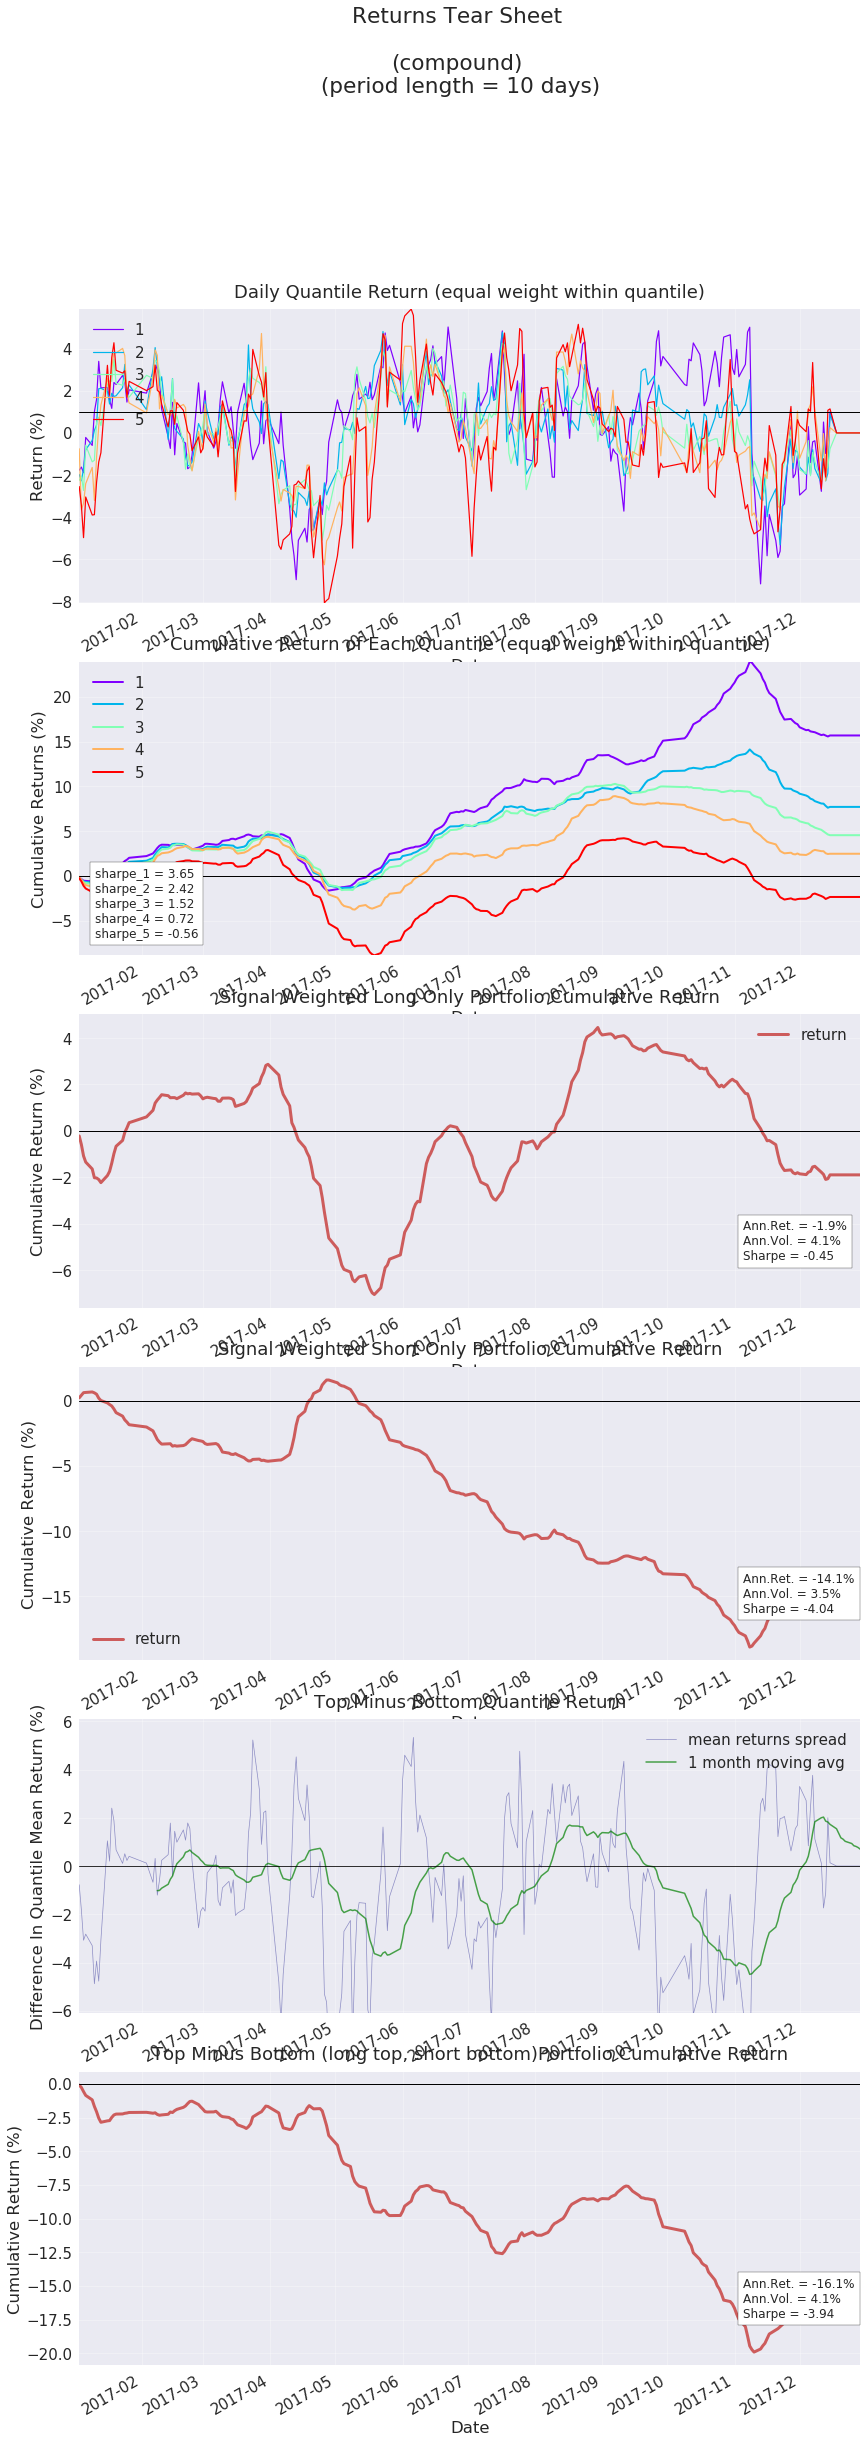

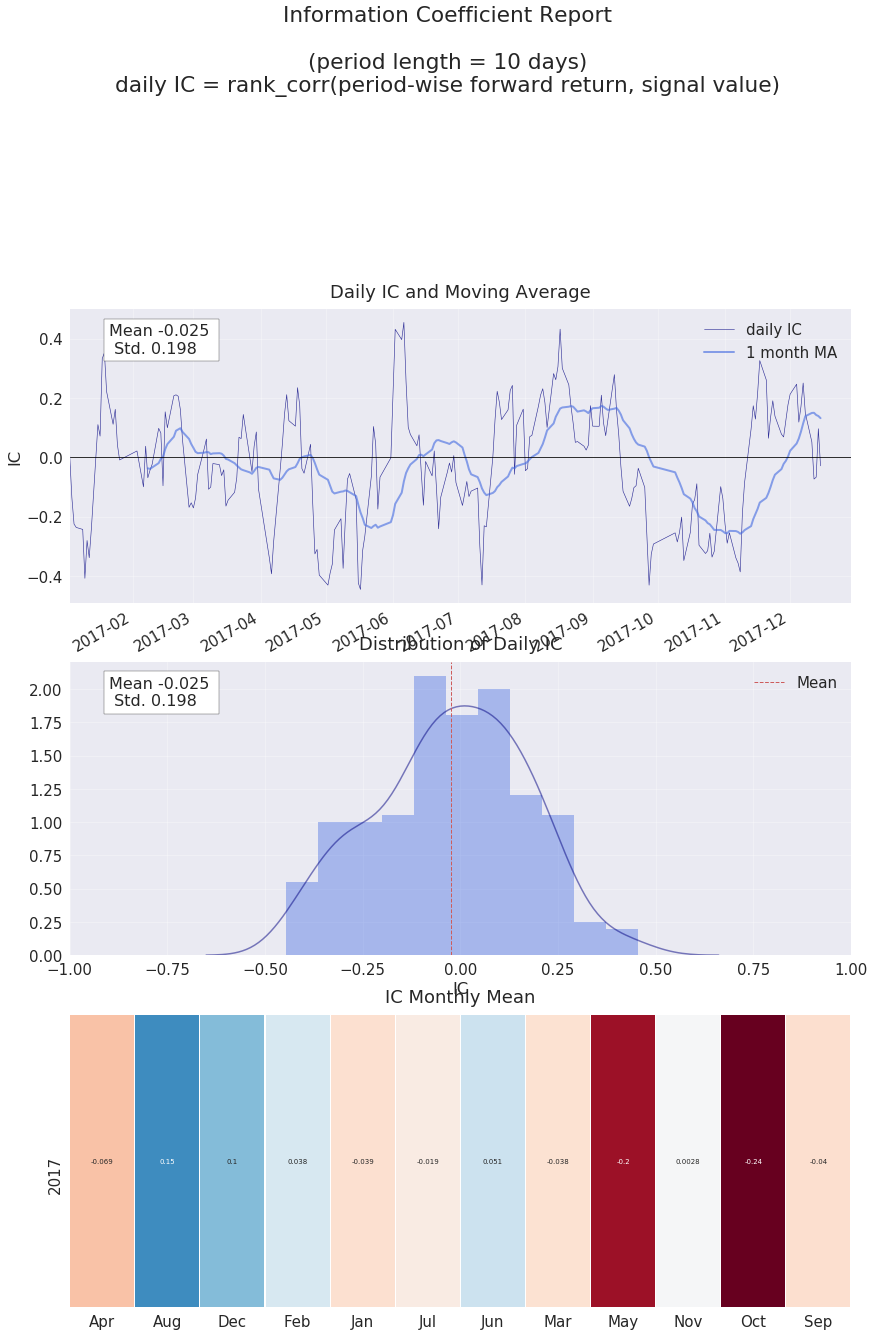

In [64]:
from jaqs_fxdayu.research import SignalDigger
from jaqs_fxdayu.research.signaldigger.analysis import analysis

import matplotlib.pyplot as plt
obj = SignalDigger()

def draw_analysis(signal_data,period):  
    obj.signal_data = signal_data
    obj.period = period
    obj.create_full_report()
    plt.show()
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20170101:], period=10)